# Análisis exploratorio y Analytics

## Modelo de DWH

### Reporte de sensado
**Dimensiones**
- Time: hour, weekday, monthday, month, season, year
- Device: Device, Module, Ambience
- Sensor

**Hechos**
- light
- movement
- power_consumption
- temperature
- sound

### Consumo de energía
**Dimensiones**
- Time: minday (minute + hour), weekday, day, month, season, year
- Device: Device, Module

**Hechos**
- power_consumption
- acc_power_consumption

#### Modelo de datos
**fk_power_consumption**
- id_power_consumption: int (SK)
- id_time: int (fk)
- id_mod: int (fk)
- power_consumption: float

**lk_module** (se puede utilizar device_modules de la db transaccional)
- id_mod: int (PK)
- device_id: int
- module_id: int

**lk_time**
- id_time: int (PK)
- minute: int
- hour: int
- day: int
- weekday: int
- month: int
- season: int
- year: int

## Import de librerías

In [752]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
from datetime import datetime, timedelta
import MySQLdb
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

## Configuración
### Conexión a bases de datos

In [604]:
# Base de datos transaccional
dbname_trx = "ratio_dwh"
dbhost_trx = "localhost"
dbport_trx = 3306
dbuser_trx = "root"
dbpass_trx = "root"

# Base de datos histórica
dbname_hist = "ratio_dwh"
dbhost_hist = "localhost"
dbport_hist = 3306
dbuser_hist = "root"
dbpass_hist = "root"

### Tablas de consulta (fuentes de datos)

In [605]:
devices_tbl = "devices"
device_modules_tbl = "device_modules"
module_types_tbl = "module_types"
sensor_types_tbl = "sensor_types"
device_events_tbl = "device_events"
device_event_sensors_tbl = "device_event_sensors"

### Esquema del DWH

In [606]:
fk_power_consumption = "fk_power_consumption"
lk_module = "lk_module"
lk_time = "lk_time"

### Variables globales

In [607]:
# Voltaje de la red (en V)
voltage = 230
# Sensor_type_id de energia: 1
sensor_type_id = 1
# Día 1 del período de facturación
invoice_period_start_day = 3

## Integración de datos Transaccionales a DWH (ETL)
### Extracción de datos de la base Transaccional

In [608]:
conn = MySQLdb.connect(host=dbhost_trx, port=dbport_trx, user=dbuser_trx, passwd=dbpass_trx, db=dbname_trx)
# Dimensiones de devices y modulos
proy_sql = 'M.id as MOD_ID, M.name as MOD_NAME, module_type_id as MOD_TYPE_ID, MT.name as MOD_TYPE_NAME, D.id as DEV_ID, D.name as DEV_NAME'
tables_sql = devices_tbl + ' D JOIN ' + device_modules_tbl + ' M ON D.id=M.device_id JOIN ' + module_types_tbl + ' MT ON module_type_id=MT.id'
df_modules = pd.read_sql('SELECT ' + proy_sql + ' FROM ' + tables_sql, con=conn)
# Hechos (mediciones)
proy_sql = 'module_id as MOD_ID, ts as TIMESTAMP, state as STATE, value as CURRENT'
tables_sql = device_events_tbl + ' DE JOIN ' + device_event_sensors_tbl + ' DES ON DE.id=DES.device_event_id'
where_sql = 'sensor_type_id = ' + str(sensor_type_id)
df_events = pd.read_sql('SELECT ' + proy_sql + ' FROM ' + tables_sql + ' WHERE ' + where_sql, con=conn)
conn.close()

In [609]:
df_modules

,MOD_ID,MOD_NAME,MOD_TYPE_ID,MOD_TYPE_NAME,DEV_ID,DEV_NAME
0,51,Lux Cocina mod,1,LUX,5,Lux Cocina
1,52,Pot Cocina,2,POTENTIA,5,Lux Cocina
2,61,Pot 1,2,POTENTIA,6,Potentia Heladera
3,71,Omni 1,3,OMNI,7,Omni Cocina


In [610]:
df_events.head(5)

,MOD_ID,TIMESTAMP,STATE,CURRENT
0,51,2017-01-01 00:00:00,0,0.009875
1,51,2017-01-01 00:01:00,0,0.001407
2,51,2017-01-01 00:02:00,0,0.010199
3,51,2017-01-01 00:03:00,0,0.002434
4,51,2017-01-01 00:04:00,0,0.000344


### Chequeo de valores null

In [611]:
df_events.isnull().any()

MOD_ID       False
TIMESTAMP    False
STATE        False
CURRENT      False
dtype: bool

### Limpieza del dataset
Se verifican algunas columnas de los datasets obtenidos

In [612]:
# Duplicados en TIMESTAMP
if df_events.duplicated().any():
    print 'Se eliminan los duplicados (se mantiene el primero)'
    df_events.drop_duplicates(inplace=True,keep='first')

In [613]:
df_events.duplicated().any()

False

### Transformación de variables
Se trabajan las variables que se extraen para generar las tablas históricas en la db del DWH.
La dimensión Module no requiere trabajo adicional ya que se integró con la extracción de la base transaccional.
Por lo tanto resta generar la dimensión Tiempo con sus atributos y relacionar todas las dimensiones con la tabla de hechos.

In [614]:
# Se genera la dimensión Tiempo
df_time = pd.DataFrame(df_events.TIMESTAMP.unique(),columns=['TIMESTAMP'])
df_time['YEAR'] = df_time['TIMESTAMP'].dt.year
df_time['YEARDAY'] = df_time['TIMESTAMP'].dt.strftime('%j').astype(int)
df_time['MONTH'] = df_time['TIMESTAMP'].dt.month
df_time['WEEKDAY'] = df_time['TIMESTAMP'].dt.weekday
df_time['WEEKDAY_NAME'] = df_time['TIMESTAMP'].dt.strftime('%A')
df_time['DAY'] = df_time['TIMESTAMP'].dt.day
df_time['HOUR'] = df_time['TIMESTAMP'].dt.hour
df_time['MINUTE'] = df_time['TIMESTAMP'].dt.minute
#df_time['MINDAY'] = df_time['HOUR'] * 60 + df_time['MINUTE']

In [615]:
df_time.head(5)

,TIMESTAMP,YEAR,YEARDAY,MONTH,WEEKDAY,WEEKDAY_NAME,DAY,HOUR,MINUTE
0,2017-01-01 00:00:00,2017,1,1,6,Sunday,1,0,0
1,2017-01-01 00:01:00,2017,1,1,6,Sunday,1,0,1
2,2017-01-01 00:02:00,2017,1,1,6,Sunday,1,0,2
3,2017-01-01 00:03:00,2017,1,1,6,Sunday,1,0,3
4,2017-01-01 00:04:00,2017,1,1,6,Sunday,1,0,4


Debido a que el análisis siempre se realizará con granularidad de HORAS en la dimensión tiempo, se genera un dataframe de Tiempo con ese nivel de detalle

In [616]:
df_time_hours = df_time.query('MINUTE == 0')
del df_time_hours['MINUTE']
df_time_hours.reset_index(inplace=True,drop=True)
df_time_hours.head(5)

,TIMESTAMP,YEAR,YEARDAY,MONTH,WEEKDAY,WEEKDAY_NAME,DAY,HOUR
0,2017-01-01 00:00:00,2017,1,1,6,Sunday,1,0
1,2017-01-01 01:00:00,2017,1,1,6,Sunday,1,1
2,2017-01-01 02:00:00,2017,1,1,6,Sunday,1,2
3,2017-01-01 03:00:00,2017,1,1,6,Sunday,1,3
4,2017-01-01 04:00:00,2017,1,1,6,Sunday,1,4


#### Cálculo de consumo en energía (WATT_HOUR)
Se general la tabla de hechos (energía consumida) a partir de los eventos. Primero se calcula la energía consumida en Watts/hora. El cálculo se realiza obteniendo la media de las mediciones de corriente en cada hora de cada día del año.

Por ejemplo, a las 11am del 1/1/17 se consumieron 11,14 Watts.

In [617]:
df_events.query('TIMESTAMP >= "2017-01-01 11:00:00" & TIMESTAMP < "2017-01-01 12:00:00" & MOD_ID == 51').CURRENT.mean() * voltage

11.146453086107696

Se procede entonces a generar un dataset con el consumo en cada hora medida. Primero se obtiene una serie con todos los timestamps para cada hora del dataset df_time.

In [618]:
serie_ts_hours = df_time.iloc[df_time[['YEAR','YEARDAY','HOUR']].drop_duplicates().index].TIMESTAMP

Se genera el df_power para cada módulo del df_modules

In [619]:
df_power = pd.DataFrame(columns=['TIMESTAMP','MOD_ID','WATT_HOUR'])
for mod_id in df_modules.MOD_ID:
    if df_predict_mod.shape[0] > 0:
        # Se calcula el watt/hora para el modulo mod_id
        df_power_mod = df_events.query('MOD_ID == ' + str(mod_id)).merge(df_time,on='TIMESTAMP').groupby(['YEAR','YEARDAY','HOUR']).CURRENT.mean() * voltage
        # Eliminamos el indice multiple para aplanar y convertir de Serie a Dataframe
        df_power_mod = df_power_mod.reset_index()
        # Se agrega el TIMESTAMP para utilizarlo como FK de la dimension tiempo y se renombra la columna de consumo
        df_power_mod = df_power_mod.merge(df_time_hours[['TIMESTAMP','YEAR','YEARDAY','HOUR']],left_on=['YEAR','YEARDAY','HOUR'], right_on=['YEAR','YEARDAY','HOUR'])
        df_power_mod.rename(columns={'CURRENT': 'WATT_HOUR'},inplace=True)
        # Eliminamos columnas que no se grabaran en la tabla de hechos
        df_power_mod.drop(['YEAR','YEARDAY','HOUR'],axis=1,inplace=True)
        # Se asigna el mod_id calculado
        df_power_mod = df_power_mod.assign(MOD_ID = mod_id)
    
        # Se agrega los consumos del mod_id a la tabla de hechos
        df_power = pd.concat([df_power,df_power_mod])

Se verifica que el valor de consumo por hora es correcto (según lo visto previamente en el ejemplo)

In [620]:
df_power.query('TIMESTAMP == "2017-01-01 11:00:00" & MOD_ID == 51')

,MOD_ID,TIMESTAMP,WATT_HOUR
11,51,2017-01-01 11:00:00,11.146453


#### Se prueba la integración de las tablas de dimensiones con la tabla de hechos
Se arma el cubo

In [621]:
df_power_cube = df_power.merge(df_modules,on='MOD_ID').merge(df_time_hours,on='TIMESTAMP')
df_power_cube.head(5)

,MOD_ID,TIMESTAMP,WATT_HOUR,MOD_NAME,MOD_TYPE_ID,MOD_TYPE_NAME,DEV_ID,DEV_NAME,YEAR,YEARDAY,MONTH,WEEKDAY,WEEKDAY_NAME,DAY,HOUR
0,51,2017-01-01 00:00:00,2.459562,Lux Cocina mod,1,LUX,5,Lux Cocina,2017,1,1,6,Sunday,1,0
1,52,2017-01-01 00:00:00,78.473049,Pot Cocina,2,POTENTIA,5,Lux Cocina,2017,1,1,6,Sunday,1,0
2,51,2017-01-01 01:00:00,4.477683,Lux Cocina mod,1,LUX,5,Lux Cocina,2017,1,1,6,Sunday,1,1
3,52,2017-01-01 01:00:00,53.816835,Pot Cocina,2,POTENTIA,5,Lux Cocina,2017,1,1,6,Sunday,1,1
4,51,2017-01-01 02:00:00,4.222319,Lux Cocina mod,1,LUX,5,Lux Cocina,2017,1,1,6,Sunday,1,2


## Análisis de consumo de energía

Se realizará un análisis exploratorio inicial para luego armar un modelo predictivo de consumo de energía de un mes específico según el consumo acumulado hasta el momento actual.
Para lograrlo se establecerá:
- Variable objetivo: WATT_HOUR_MONTH (consumo en watt/hora del módulo en el mes)
- Variables predictoras:
    - MOD_ID
    - MONTH
    - MONTH_HOUR
    - WATT_HOUR_ACC (consumo acumulado hasta el día actual)
    
Debido a que se trata de una variable continua, se implementará un modelo basado en **regresión lineal**.


### Verificando dataset completo
Para realizar un modelo predictivo es necesario contar con un dataset completo que no tenga saltos en las mediciones. Por lo tanto, se debe verificar que cuente con datos en todos las horas del mes a analizar.

In [622]:
df_power_cube.isnull().any()

MOD_ID           False
TIMESTAMP        False
WATT_HOUR        False
MOD_NAME         False
MOD_TYPE_ID      False
MOD_TYPE_NAME    False
DEV_ID           False
DEV_NAME         False
YEAR             False
YEARDAY          False
MONTH            False
WEEKDAY          False
WEEKDAY_NAME     False
DAY              False
HOUR             False
dtype: bool

#### Corrigiendo valores null
Podríamos utilizar diferentes opciones:
- pad: se rellena con el último valor
- interpolate: se rellena con valores interpolados de la columna (quizá el más apropiado para valores continuos).
    La interpolacion puede ser:
    - Lineal
    - Cuadratica
    - Cubica
- escalar: se rellena con un número específico

In [623]:
#df_test_interp = pd.DataFrame(df_power_cube.TEMPERATURE.interpolate(method='linear'), columns=['TEMP_L'] )
#df_test_interp['TEMP_Q'] = df_power_cube.TEMPERATURE.interpolate(method='quadratic')
#df_test_interp['TEMP_C'] = df_power_cube.TEMPERATURE.interpolate(method='cubic')
#df_test_interp.plot()

### Generando variable objetivo
Se define el valor de consumo mensual

In [624]:
df_predict = df_power_cube.groupby(['YEAR','MONTH','MOD_ID']).WATT_HOUR.sum().astype(int)
df_predict = df_predict.reset_index()
df_predict = df_predict.rename(columns={'WATT_HOUR': 'WATT_HOUR_MONTH'})
df_predict = df_predict.merge(df_power_cube,on=['YEAR','MONTH','MOD_ID'])
df_predict.set_index('TIMESTAMP',inplace=True)

Validando el consumo mensual generado

In [625]:
df_predict.query('MOD_ID == 52 & TIMESTAMP >= "2017-01-01" & TIMESTAMP < "2017-02-01"').WATT_HOUR.sum()

59758.668043696336

In [626]:
df_predict.query('MOD_ID == 52 & YEAR == 2017 & MONTH == 1').WATT_HOUR_MONTH[0]

59758

### Generando variables predictoras
Se generan las siguientes variables:
- MONTH_HOUR: Hora relativa al mes
- WATT_HOUR_ACC: Consumo en watt/hora acumulado desde el principio de mes

In [627]:
df_predict['MONTH_HOUR'] = (df_predict.DAY-1) * 24 + df_predict.HOUR
for mod_id in df_modules.MOD_ID:
    if df_predict_mod.shape[0] > 0:
        mod_cumsum = df_predict.query('MOD_ID == ' + str(mod_id)).groupby(['YEAR','MONTH','MOD_ID']).WATT_HOUR.cumsum().astype(int)
        df_predict.loc[ df_predict.MOD_ID == mod_id, 'WATT_HOUR_ACC'] = mod_cumsum

In [628]:
df_predict.head(5)

,YEAR,MONTH,MOD_ID,WATT_HOUR_MONTH,WATT_HOUR,MOD_NAME,MOD_TYPE_ID,MOD_TYPE_NAME,DEV_ID,DEV_NAME,YEARDAY,WEEKDAY,WEEKDAY_NAME,DAY,HOUR,MONTH_HOUR,WATT_HOUR_ACC
TIMESTAMP,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017,1,51,6663,2.459562,Lux Cocina mod,1,LUX,5,Lux Cocina,1,6,Sunday,1,0,0,2.0
2017-01-01 01:00:00,2017,1,51,6663,4.477683,Lux Cocina mod,1,LUX,5,Lux Cocina,1,6,Sunday,1,1,1,6.0
2017-01-01 02:00:00,2017,1,51,6663,4.222319,Lux Cocina mod,1,LUX,5,Lux Cocina,1,6,Sunday,1,2,2,11.0
2017-01-01 03:00:00,2017,1,51,6663,4.788357,Lux Cocina mod,1,LUX,5,Lux Cocina,1,6,Sunday,1,3,3,15.0
2017-01-01 04:00:00,2017,1,51,6663,3.241812,Lux Cocina mod,1,LUX,5,Lux Cocina,1,6,Sunday,1,4,4,19.0


### Análisis univariado
Se analizan algunas variables por separado para conocer sus medidas de tendencia central y dispersión. Se debe considerar que se construirá un modelo predictivo para cada módulo, por lo cual para ejemplificar siempre filtraremos el módulo 52.

#### Consumo por hora a lo largo de un mes

In [728]:
df_predict_mod = df_predict.query('MOD_ID == 52')

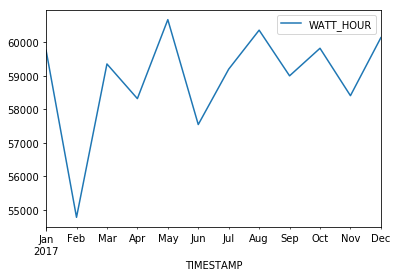

In [715]:
plot_consumo = df_predict_mod.resample('MS').sum()
plot_consumo.plot(plot_consumo.index,['WATT_HOUR'])

#### Variables descriptivas del consumo mensual

In [716]:
df_predict_mod['WATT_HOUR_MONTH'].describe()

count     8760.000000
mean     58985.583562
std       1492.407943
min      54783.000000
25%      58406.000000
50%      59350.000000
75%      60134.000000
max      60671.000000
Name: WATT_HOUR_MONTH, dtype: float64

#### Variables descriptivas del consumo por hora acumulado

In [717]:
df_predict_mod['WATT_HOUR_ACC'].describe()

count     8760.000000
mean     29486.650571
std      17062.067615
min         49.000000
25%      14752.000000
50%      29453.000000
75%      44212.250000
max      60671.000000
Name: WATT_HOUR_ACC, dtype: float64

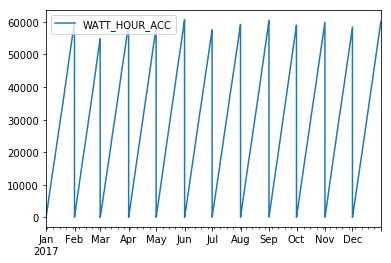

In [718]:
plot_consumo = df_predict_mod.resample('H').mean()
plot_consumo.plot(plot_consumo.index.values,['WATT_HOUR_ACC'])

La variable predictora de mayor fuerza será seguramente el consumo acumulado por hora del mes. Por lo tanto, en principio miramos estas variables con mayor atención.

La cantidad de muestras coincide y el máximo también, lo cual tiene sentido. Avanzamos con análisis bivariado...

### Análisis bivariado
En primer lugar analizaremos la relación entre variables predictoras:

In [719]:
df_predict_mod.corr()[['WATT_HOUR','WATT_HOUR_ACC','MONTH_HOUR']]

,WATT_HOUR,WATT_HOUR_ACC,MONTH_HOUR
YEAR,NaN,NaN,NaN
MONTH,0.004867,0.015869,0.011887
WATT_HOUR_MONTH,-0.003259,0.043303,0.045191
WATT_HOUR,1.000000,0.009410,0.008231
MOD_TYPE_ID,NaN,NaN,NaN
DEV_ID,NaN,NaN,NaN
YEARDAY,0.005638,0.099074,0.095080
WEEKDAY,-0.023082,-0.011886,-0.012145
DAY,0.008497,0.999248,0.999463
HOUR,-0.007991,0.032760,0.032772


La única relación importante se da entre la hora relativa del mes y el consumo acumulado, los cuales son prácticamente lineales. En el futuro quizá es posible prescindir de una de ellas pero puede que sea necesario mantener ambas en caso de requerir predicción sobre sólo una de ellas.

#### Correlación con variable objetivo

In [720]:
df_predict_mod.corr()['WATT_HOUR_MONTH']

YEAR                        NaN
MONTH              3.340440e-01
WATT_HOUR_MONTH    1.000000e+00
WATT_HOUR         -3.259326e-03
MOD_TYPE_ID                 NaN
DEV_ID                      NaN
YEARDAY            3.329301e-01
WEEKDAY           -1.309393e-02
DAY                4.521501e-02
HOUR              -4.020222e-20
MONTH_HOUR         4.519072e-02
WATT_HOUR_ACC      4.330337e-02
Name: WATT_HOUR_MONTH, dtype: float64

In [636]:
def plot_corr(df, size=10):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

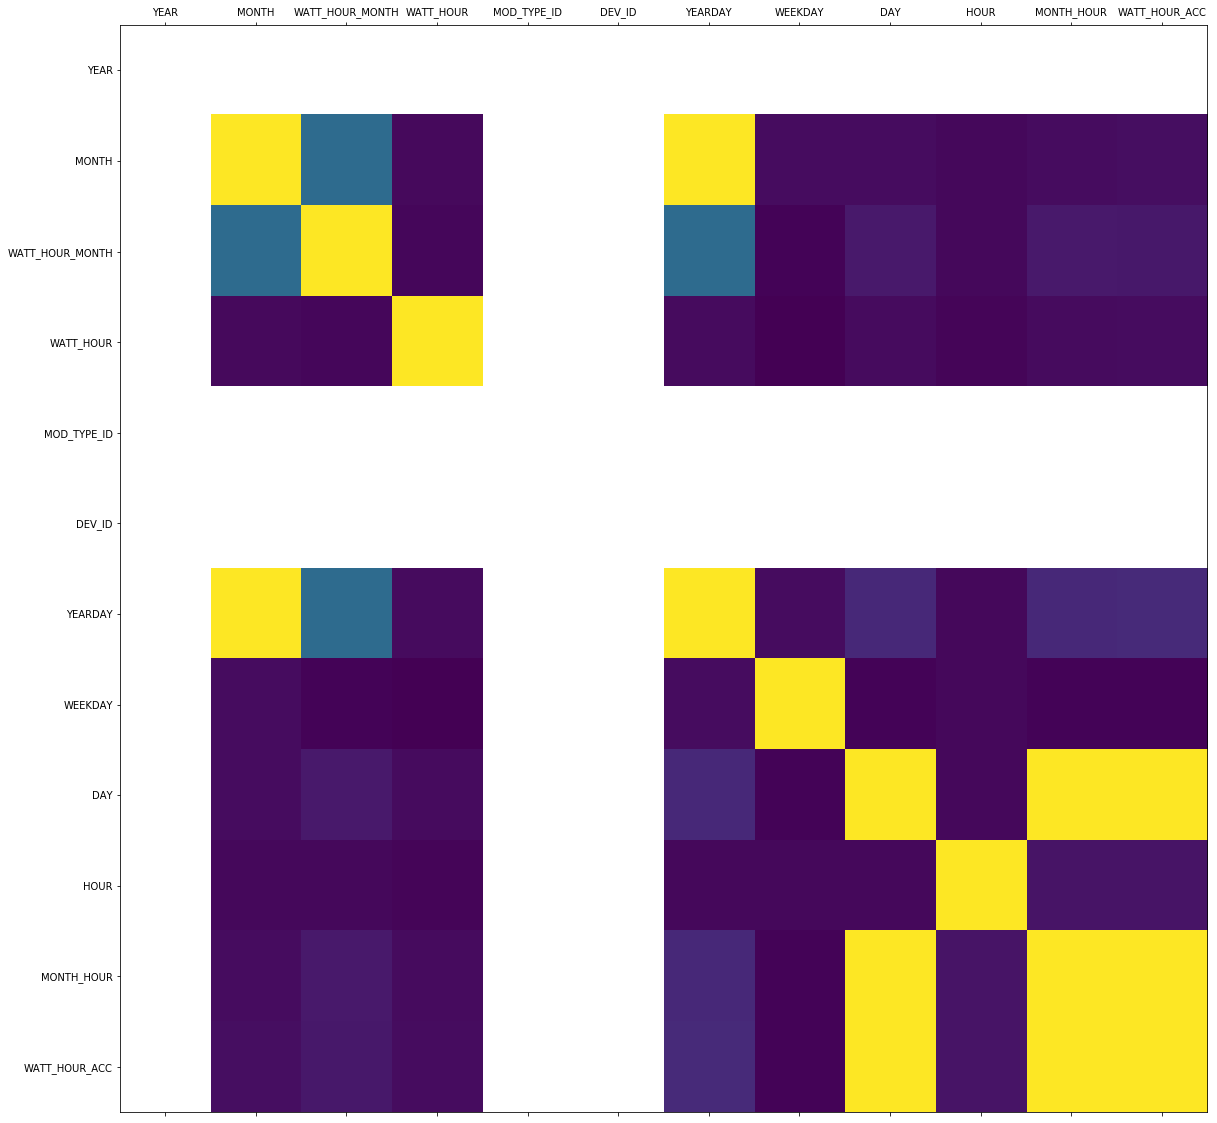

In [721]:
plot_corr(df_predict_mod,20)

Analizando la correlación entre las variables se deduce que es difícil realizar la regresión lineal a través de una única variable ya que la correlación de la variable objetivo con el resto es bastante débil. Entonces aprovecharemos a incorporar las variables de consumo acumulado junto con su hora relativa del mes para ver si con la combinación de ambas es posible entrenar y predecir una regresión.

## Entrenamiento y verificación de RNA

### Modelo #1 - Variable objetivo: Consumo Mensual (WATT_HOUR_MONTH)

In [722]:
df_predict_mod.head(1)

,YEAR,MONTH,MOD_ID,WATT_HOUR_MONTH,WATT_HOUR,MOD_NAME,MOD_TYPE_ID,MOD_TYPE_NAME,DEV_ID,DEV_NAME,YEARDAY,WEEKDAY,WEEKDAY_NAME,DAY,HOUR,MONTH_HOUR,WATT_HOUR_ACC
TIMESTAMP,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,52,59758,78.473049,Pot Cocina,2,POTENTIA,5,Lux Cocina,1,6,Sunday,1,0,0,78.0


#### Separando los datos para training y prueba
Para poder hacer etapas de entrenamiento y prueba, voy a separar los datos. 70% para entrenamiento, 30% para prueba.

Los conjuntos de datos van a llamarse:
* features_train: Datos de entrenamiento. Las columnas que representan las variables predictoras, compuesto por el 70% de los registros.
* goal_train: Objetivo de entrenamiento. Columna que representa la variable objetivo para el 70% de los registros
* features_test: Datos para hacer la validación. Tienen el mismo formato que features_train, pero corresponden al 30% del conjunto de datos
* goal_test: Resultados para validar la performance del algoritmo aplicado a features_test

In [723]:
features_names = ['MONTH_HOUR','WATT_HOUR_ACC']
goal_names = ['WATT_HOUR_MONTH']

features_data = df_predict_mod[features_names].values     # Columnas del predictor
goal_data = df_predict_mod[goal_names].values            # Valor predecido
split_test_size = 0.30                                       # 0.30 es 30%, el tamaño para pruebas

features_train, features_test, goal_train, goal_test = train_test_split(features_data, goal_data, test_size=split_test_size)

Se verifica que el tamaño relativo de los sets de entrenamiento y prueba sea lo más cercano a 70-30 posible:

In [724]:
print "{0:.2f}% en el set de entrenamiento".format(float(features_train.shape[0])/df_predict_mod.shape[0] * 100 ) 
print "{0:.2f}% en el set de prueba".format(float(features_test.shape[0])/df_predict_mod.shape[0] * 100)

70.00% en el set de entrenamiento
30.00% en el set de prueba


#### Entrenamiento inicial
Para este entrenamiento se utilizará un algoritmo de machine learning basado en un perceptrón multicapa (MPL) de la librería scikit-learn: neural_network. 
Como lo que estamos tratando de predecir es el consumo mensual de un módulo estamos hablando de un algoritmo de regresión y, dado que la variable dependiente es continua, se utiliza la regresión lineal (aunue no necesariamente la misma se representa con una relación lineal con las variables independientes.

El algoritmo a implementar para optimizar la diferencia de cuadrados es el LBFGS, aunque el resultado final depende de la función activación que se seleccione, por lo tanto haremos algunas pruebas para determinar el mejor método de regresión al momento del entrenamiento de la red neuronal artificial.

In [725]:
activation_types = [ 'identity', 'logistic', 'tanh', 'relu' ]
for act in activation_types:
    mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=100, max_iter=300, shuffle=True, activation=act)
    mlp.fit(features_train, goal_train.ravel())
    
    print 'Score de entrenamiento con activación {0}: {1:.4f}'.format(act,mlp.score(features_test, goal_test))

Score de entrenamiento con activación identity: 0.0104
Score de entrenamiento con activación logistic: -0.0003
Score de entrenamiento con activación tanh: -0.0008
Score de entrenamiento con activación relu: -372.5328


Las pruebas de entrenamiento claramente no son positivas ya que el modelo más optimista es el de la función de activación de identidad, pero cerca del 0,01...

Se procede entonces a un modelo diferente para analizar.

### Modelo #2 - Variable objetivo: Porcentaje de Consumo Acumulado
Dado que la variable de valor acumulado tiene en su punto máximo el mismo valor que la variable objetivo buscada (consumo mensual), es correcto armar un modelo que permita predecir su crecimiento a lo largo del mes. 

El objetivo es predecir el ritmo con el cual crece el consumo acumulado a cada hora del mes. Por lo tanto se genera una nueva variable llamada TOTAL_WATT_PER que representa el porcentaje del consumo acumulado al momento. De esta forma, se puede entrenar un modelo de regresión bivaluado entre la hora relativa del mes y el el porcentaje de consumo. Es la forma más simple de alcanzar una regresión que represente cómo crece el consumo hora a hora en cada mes.

In [ ]:
# Preparación de nueva variable objetivo
df_predict_mod['TOTAL_WATT_PER'] = df_predict_mod.WATT_HOUR_ACC / df_predict_mod.WATT_HOUR_MONTH

# Preparación de datos (split 70/30)
features_names = ['MONTH_HOUR','MONTH']
goal_names = ['TOTAL_WATT_PER']

features_data = df_predict_mod[features_names].values        # Columnas del predictor
goal_data = df_predict_mod[goal_names].values                # Valor predecido
split_test_size = 0.30                                       # 0.30 es 30%, el tamaño para pruebas

features_train, features_test, goal_train, goal_test = train_test_split(features_data, goal_data, test_size=split_test_size)

# Entrenamiento y evaluación
activation_types = [ 'identity', 'logistic', 'tanh', 'relu' ]
for act in activation_types:
    mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=100, max_iter=300, shuffle=True, activation=act)
    mlp.fit(features_train, goal_train.ravel())
    
    print 'Score de entrenamiento con activación {0}: {1:.4f}'.format(act,mlp.score(features_test, goal_test))

El resultado de este modelo es más favorable. De todas formas, es sencillo deducir por qué la predicción tiene un score tan alto. El crecimiento de consumo para el módulo 52 es prácticamente lineal, muy estable. Es por ello que el modelo responderá muy bien. Intentaremos probarlo con todos lo módulos sensados para determinar si responde adecuadamente.

## Aplicación del modelo
Se aplica entonces el modelo a los módulos con sensado de corriente en el DWH.

In [770]:
# Preparación de nueva variable objetivo
df_predict['TOTAL_WATT_PER'] = df_predict.WATT_HOUR_ACC / df_predict.WATT_HOUR_MONTH

def create_module_regressor(mod_id):
    df_predict_mod = df_predict.query('MOD_ID == ' + str(mod_id))
    
    if df_predict_mod.shape[0] > 0:
        # Preparación de datos (split 70/30)
        features_names = ['MONTH_HOUR','MONTH']
        goal_names = ['TOTAL_WATT_PER']

        features_data = df_predict_mod[features_names].values        # Columnas del predictor
        goal_data = df_predict_mod[goal_names].values                # Valor predecido
        split_test_size = 0.30                                       # 0.30 es 30%, el tamaño para pruebas

        features_train, features_test, goal_train, goal_test = train_test_split(features_data, goal_data, test_size=split_test_size)

        # Entrenamiento y evaluación
        mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=100, max_iter=300, shuffle=True, activation='identity')
        mlp.fit(features_train, goal_train.ravel())
    
        return mlp
    else:
        return 0

for mod_id in df_modules.MOD_ID:
    mlp = create_module_regressor(mod_id)
    if mlp <> 0:
        print 'Score de entrenamiento módulo {0}: {1:.4f}'.format(mod_id,mlp.score(features_test, goal_test))

Score de entrenamiento módulo 51: 0.9963
Score de entrenamiento módulo 52: 0.9969


### Evaluación del modelo
Se analizará si el modelo es adecuado para el último de los módulos mediante el cálculo de los desvíos de la predicción.

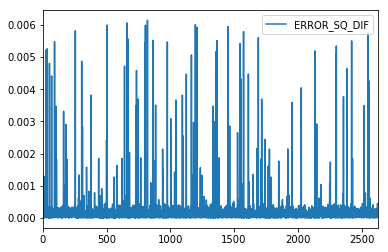

In [763]:
df_test = pd.DataFrame(features_test,columns=['MONTH_HOUR','MONTH'])
df_test['TOTAL_WATT_PER'] = goal_test
df_test['TOTAL_WATT_PER_PREDICTED'] = mlp.predict(features_test)
df_test['ERROR_SQ_DIF'] = (df_test.TOTAL_WATT_PER - df_test.TOTAL_WATT_PER_PREDICTED).pow(2)
df_test.plot(df_test.index,['ERROR_SQ_DIF'])

El resultado obtenido para el último módulo también es favorable ya que predice el porcentaje de consumo con un error mínimo (menor al 0,6%). Por lo tanto, se procede a finalizar el modelo que deberá agregar el cálculo del consumo a predecir extrapolando el consumo acumulado hasta el momento con el porcentaje restante que le corresponde.

### Predicción del consumo
Se realizará el ejemplo de predicción para los siguientes datos:
- módulo: 52
- fecha: 20/8/17 13:00
- consumo acumulado: 37818
- Consumo mensual a predecir: 60357 Watt/h

In [768]:
df_predict_test = df_predict.query('MOD_ID == 52 & TIMESTAMP == "2017-08-20 13:00:00"')
df_predict_test

,YEAR,MONTH,MOD_ID,WATT_HOUR_MONTH,WATT_HOUR,MOD_NAME,MOD_TYPE_ID,MOD_TYPE_NAME,DEV_ID,DEV_NAME,YEARDAY,WEEKDAY,WEEKDAY_NAME,DAY,HOUR,MONTH_HOUR,WATT_HOUR_ACC,TOTAL_WATT_PER
TIMESTAMP,,,,,,,,,,,,,,,,,,
2017-08-20 13:00:00,2017,8,52,60357,111.922743,Pot Cocina,2,POTENTIA,5,Lux Cocina,232,6,Sunday,20,13,469,37818.0,0.626572


In [777]:
mlp = create_module_regressor(52)
total_watt_per = mlp.predict(df_predict_test[['MONTH_HOUR','MONTH']])[0]
print 'Se predice que el porcentaje de consumo acumulado del mes es: {0}%'.format(round(total_watt_per,4)*100)

Se predice que el porcentaje de consumo acumulado del mes es: 64.09%


In [782]:
consumo_mes_pred = df_predict_test.WATT_HOUR_ACC[0] / total_watt_per
print 'Se predice que el consumo del mes será aproximadamente de {0} Watts/hora'.format(int(consumo_mes_pred))

Se predice que el consumo del mes será aproximadamente de 59005 Watts/hora
